# Data normalisation

In [1]:
import plotnine as pn
import polars as pl
import torch

from adl import model_2p
from adl.model_2p import plot_loss
from adl.sklearn import skl_regression

pl.Config(tbl_rows=30, float_precision=2)
pn.theme_set(pn.theme_minimal() + pn.theme(plot_background=pn.element_rect(fill="white")))

Dans ce tp nous allons regarder un aspect un peu plus compliqué du deep learning, un modèle avec deux paramètres ainsi que l'effet de la normalisation des données sur le processus d'entraînement.

# Data

Un jeu donnée qui nous servira pour le tp , la température et la quantité de glace vendu dans un magasin.

In [2]:
temperature = [-1.5, 0.2, 3.4, 4.1, 7.8, 13.4, 18.0, 21.5, 32.0, 33.5]
icecream = [100.5, 110.2, 133.5, 141.2, 172.8, 225.1, 251.0, 278.9, 366.7, 369.9]

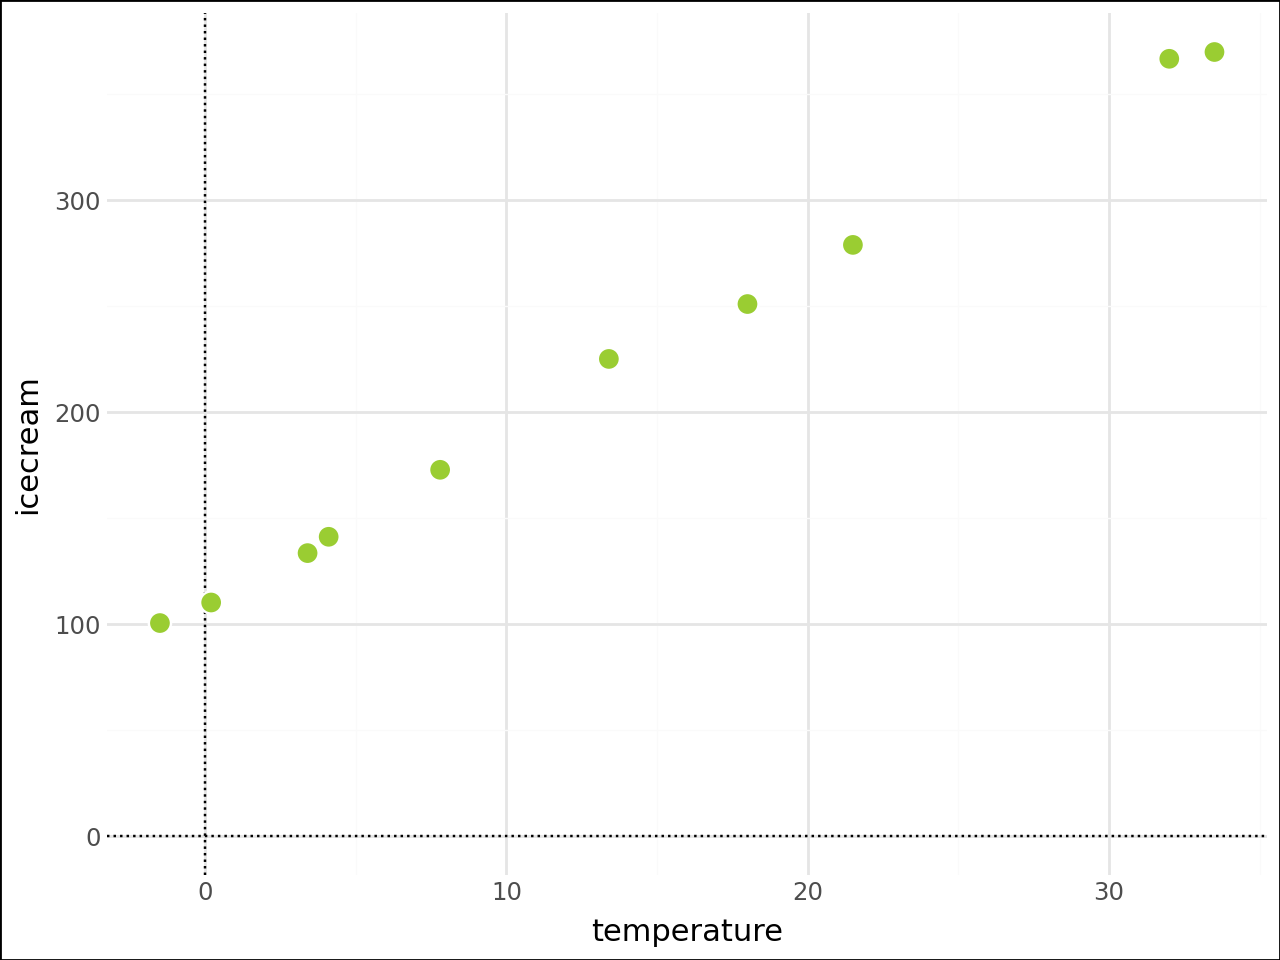

In [3]:
(
    pn.ggplot(mapping=pn.aes(x=temperature, y=icecream))
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.geom_vline(xintercept=0, linetype="dotted")
    + pn.geom_point(color="white", fill="yellowgreen", size=4)
    + pn.labs(x="temperature", y="icecream")
)

On va essayé de prédire les quantités de glace à partir de la température avec un modèle linéaire simple avec une pente et une ordonnée à l'origine : $y = w \times x + b$. Notre modèle à maintenat 2 paramètre un **poids** $w$ et un **biais** $b$.

# Regression avec scikit-learn

Nous allons d'abord calculer les valeurs "réelles" optimales de la pente et de l'ordonnée à l'origine avec scikit-learn.


In [4]:
reg = skl_regression(x=temperature, y=icecream, fit_intercept=True)
print(f"slope: {reg['slope']:.2f}, intercept: {reg['intercept']:.2f}, mse: {reg['mse']:.4f}")

slope: 7.89, intercept: 110.51, mse: 14.5403


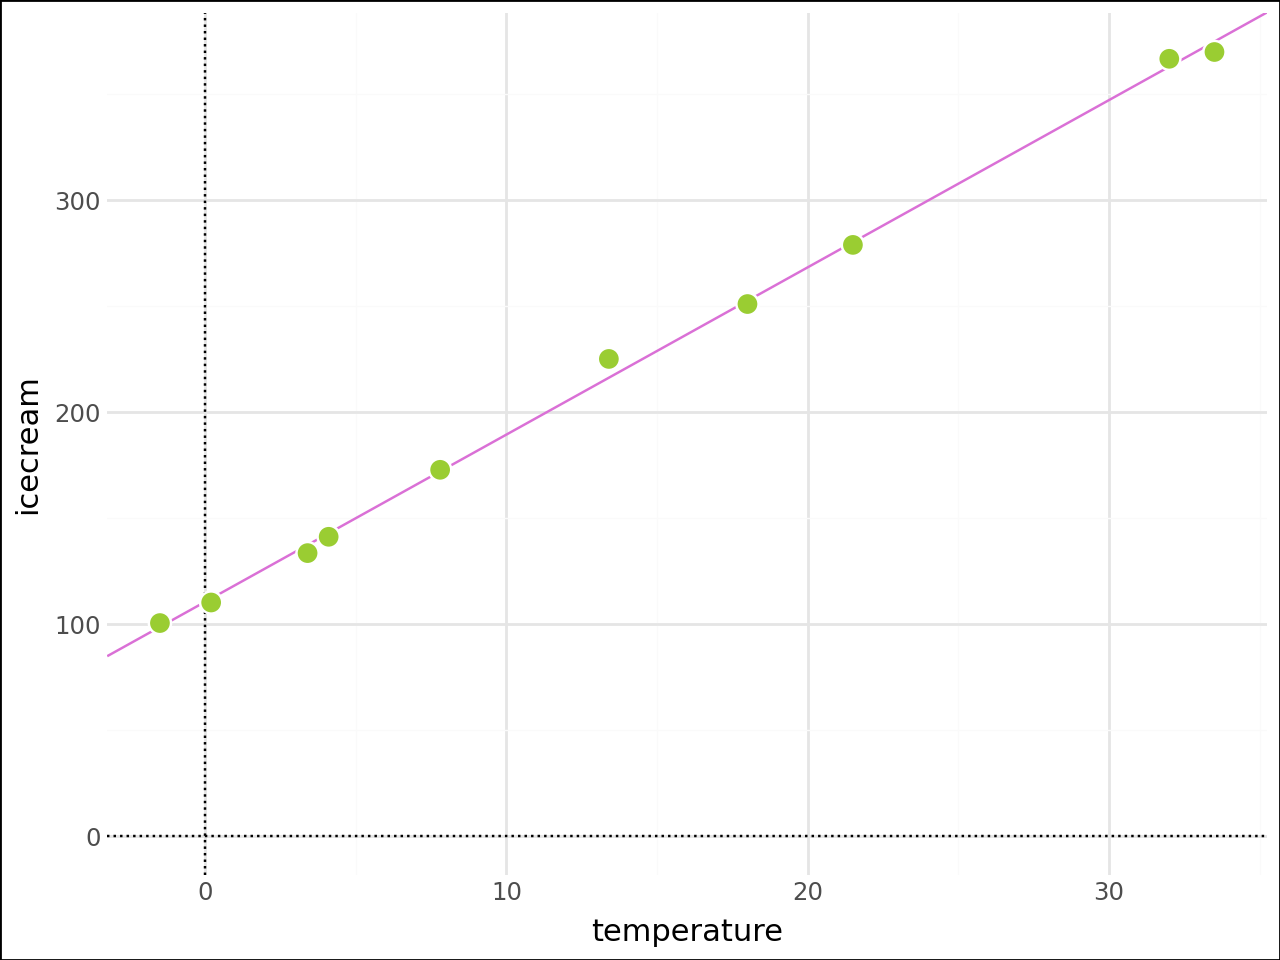

In [5]:
(
    pn.ggplot(mapping=pn.aes(x=temperature, y=icecream))
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.geom_vline(xintercept=0, linetype="dotted")
    + pn.geom_abline(slope=reg["slope"], intercept=reg["intercept"], color="orchid")
    + pn.geom_point(color="white", fill="yellowgreen", size=4)
    + pn.labs(x="temperature", y="icecream")
)

# Regression avec Pytorch 

Comme nous l'avons fait dans le précédent tp, on peut fait la même chose avec pytorch pour chercher $w$ et $b$ qui vont minimisez l'erreur (la distance) moyenne quadratique de notre modèle.

**Exercice**

À l'aide de pytorch, écrivez et exécutez le code mettant en œuvre le processus d'apprentissage
afin de trouver les valeurs de $w$ et $b$ qui minimisent l'erreur quadratique moyenne
entre les valeurs réelles et les valeurs prédites.

Le code sera assez similaire à celui du notebook précédent,
à l'exception près que nous avons désormais deux paramètres à ajuster à chaque étape.

1.  créez les tenseurs d'entrée, de cible et de paramètres
2.  créez une méthode `forward()` qui applique notre modèle aux données d'entrée
    passées en argument
3.  créez une fonction de perte à l'aide d'une des méthodes prédéfinies de pytorch
4.  implémentez un processus d'apprentissage à l'aide d'une boucle `for`

Exécutez ce processus d'apprentissage pendant 20 époques avec un pas de 0,001. Affichez
les valeurs d'époque, de perte, $w$ et $b$ à chaque étape.

À partir de maintenant, nous utiliserons une fonction prédéfinie pour notre processus d'apprentissage afin de
suivre les différentes valeurs de perte, de gradient et de paramètre à chaque
étape d'apprentissage.

Avec une taille de pas de 0,001, nous voyons que le poids de notre modèle (la
pente de la ligne de régression) augmente au cours des premières époques, puis commence
à diminuer très lentement. Le biais augmente, mais aussi très lentement.


In [6]:
def training_model2d(x,y,w,b,epochs,learning_rate):
    x = torch.tensor(x)
    y = torch.tensor(y)

    w = torch.tensor(w, requires_grad=True)
    b = torch.tensor(b, requires_grad=True)

    def forward(x):
        return x * w + b

    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        y_pred = forward(x)
        loss = loss_fn(y_pred,y)
        loss.backward()

        w.data = w.data - learning_rate * w.grad
        b.data = b.data - learning_rate * b.grad
        print(f"Epoch {epoch+1}: loss={loss.item()}, gradient.w: {w.grad}, w={w.item()}, gradient.b:{b.grad},  b={b.item()}")
        w.grad.zero_()
        b.grad.zero_()

training_model2d(temperature, icecream, 0.0, 0.0, epochs=20, learning_rate=0.001)
    

Epoch 1: loss=55261.4921875, gradient.w: -7981.73828125, w=7.981738567352295, gradient.b:-429.96002197265625,  b=0.4299600422382355
Epoch 2: loss=11868.830078125, gradient.w: -2856.357177734375, w=10.838095664978027, gradient.b:-217.74363708496094,  b=0.6477037072181702
Epoch 3: loss=6292.8720703125, gradient.w: -1020.48876953125, w=11.8585844039917, gradient.b:-141.67181396484375,  b=0.7893755435943604
Epoch 4: loss=5568.86962890625, gradient.w: -362.89813232421875, w=12.221482276916504, gradient.b:-114.36592864990234,  b=0.9037414789199829
Epoch 5: loss=5467.39697265625, gradient.w: -127.3565673828125, w=12.348838806152344, gradient.b:-104.52766418457031,  b=1.008269190788269
Epoch 6: loss=5445.810546875, gradient.w: -42.98983383178711, w=12.391828536987305, gradient.b:-100.94621276855469,  b=1.1092153787612915
Epoch 7: loss=5434.4892578125, gradient.w: -12.772624969482422, w=12.404601097106934, gradient.b:-99.60594940185547,  b=1.2088212966918945
Epoch 8: loss=5424.5009765625, gradi

Si on augmente le taux à 0.002, la loss descent va au minimum local un peu plus vite. Mais la valeur oscille autour de la valeur optimale.

In [7]:
training_model2d(temperature, icecream, 0.0, 0.0, epochs=20, learning_rate=0.002)

Epoch 1: loss=55261.4921875, gradient.w: -7981.73828125, w=15.96347713470459, gradient.b:-429.96002197265625,  b=0.859920084476471
Epoch 2: loss=9476.861328125, gradient.w: 2269.0244140625, w=11.42542839050293, gradient.b:-5.527284622192383,  b=0.8709746599197388
Epoch 3: loss=5775.90673828125, gradient.w: -638.2655029296875, w=12.701959609985352, gradient.b:-125.67271423339844,  b=1.1223200559616089
Epoch 4: loss=5460.14306640625, gradient.w: 186.27880859375, w=12.329401969909668, gradient.b:-91.36747741699219,  b=1.305055022239685
Epoch 5: loss=5416.7431640625, gradient.w: -47.584320068359375, w=12.42457103729248, gradient.b:-100.8673324584961,  b=1.5067896842956543
Epoch 6: loss=5395.31689453125, gradient.w: 18.733234405517578, w=12.387104988098145, gradient.b:-97.94379425048828,  b=1.7026772499084473
Epoch 7: loss=5375.72216796875, gradient.w: -0.08442306518554688, w=12.387273788452148, gradient.b:-98.54411315917969,  b=1.8997654914855957
Epoch 8: loss=5356.3408203125, gradient.w: 

Avec 0.003 la la valeur de la loss oscille beaucoup plus autour de la valeur optimale.

In [8]:
training_model2d(temperature, icecream, 0.0, 0.0, epochs=20, learning_rate=0.003)

Epoch 1: loss=55261.4921875, gradient.w: -7981.73828125, w=23.945215225219727, gradient.b:-429.96002197265625,  b=1.2898800373077393
Epoch 2: loss=48085.5859375, gradient.w: 7394.404296875, w=1.762002944946289, gradient.b:206.68905639648438,  b=0.6698128581047058
Epoch 3: loss=41935.95703125, gradient.w: -6835.0654296875, w=22.26719856262207, gradient.b:-381.9625549316406,  b=1.8157005310058594
Epoch 4: loss=36665.28125, gradient.w: 6333.20361328125, w=3.267587661743164, gradient.b:163.30682373046875,  b=1.3257800340652466
Epoch 5: loss=32147.384765625, gradient.w: -5853.04833984375, w=20.826732635498047, gradient.b:-340.78271484375,  b=2.348128318786621
Epoch 6: loss=28274.16796875, gradient.w: 5424.37744140625, w=4.553600311279297, gradient.b:126.22814178466797,  b=1.969443917274475
Epoch 7: loss=24953.091796875, gradient.w: -5012.041015625, w=19.589723587036133, gradient.b:-305.4418029785156,  b=2.8857693672180176
Epoch 8: loss=22104.91015625, gradient.w: 4646.0478515625, w=5.651579

Avec 0.004, le processus d'entraînement devient divergent. On voit bien que les poids oscille et s'éloigne grande de la valeur optimale.

In [9]:
training_model2d(temperature, icecream, 0.0, 0.0, epochs=20, learning_rate=0.004)

Epoch 1: loss=55261.4921875, gradient.w: -7981.73828125, w=31.92695426940918, gradient.b:-429.96002197265625,  b=1.719840168952942
Epoch 2: loss=127695.0, gradient.w: 12519.787109375, w=-18.152196884155273, gradient.b:418.9054260253906,  b=0.04421842098236084
Epoch 3: loss=305665.3125, gradient.w: -19610.8984375, w=60.29139709472656, gradient.b:-910.541748046875,  b=3.6863856315612793
Epoch 4: loss=742856.3125, gradient.w: 30745.302734375, w=-62.6898193359375, gradient.b:1173.928955078125,  b=-1.0093302726745605
Epoch 5: loss=1816748.75, gradient.w: -48174.578125, w=130.0084991455078, gradient.b:-2092.0048828125,  b=7.358689785003662
Epoch 6: loss=4454515.0, gradient.w: 75511.1328125, w=-172.0360565185547, gradient.b:3027.382568359375,  b=-4.750840663909912
Epoch 7: loss=10933502.0, gradient.w: -118333.109375, w=301.29638671875, gradient.b:-4994.97705078125,  b=15.229068756103516
Epoch 8: loss=26847338.0, gradient.w: 185465.734375, w=-440.56658935546875, gradient.b:7578.826171875,  b=-

# Représentation graphique

Pour essayer de comprendre pourquoi le processus d'apprentissage ne semble pas capable d'
atteindre les valeurs optimales de poids et de biais, nous pouvons essayer de représenter la
perte graphiquement.

Dans le graphique ci-dessous, l'espace des valeurs possibles pour le poids $w$ et le biais
$b$ est divisé en une grille. À chaque point de la grille, la valeur de la perte est
représentée par un cercle dont le rayon varie. Le gradient de la fonction de perte
à chaque point est représenté par une flèche rouge : son orientation
indique la « direction » dans laquelle les paramètres doivent être modifiés afin que la
valeur de perte augmente autant que possible, et sa longueur est
proportionnelle à l'ampleur de cette augmentation. Ainsi, si nous voulons que notre
valeur de perte diminue, nous devons suivre la direction opposée indiquée par
ces flèches.

Le point bleu au centre correspond aux valeurs optimales des paramètres, c'est-à-dire les
valeurs de $w$ et $b$ pour lesquelles la perte est minimale.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


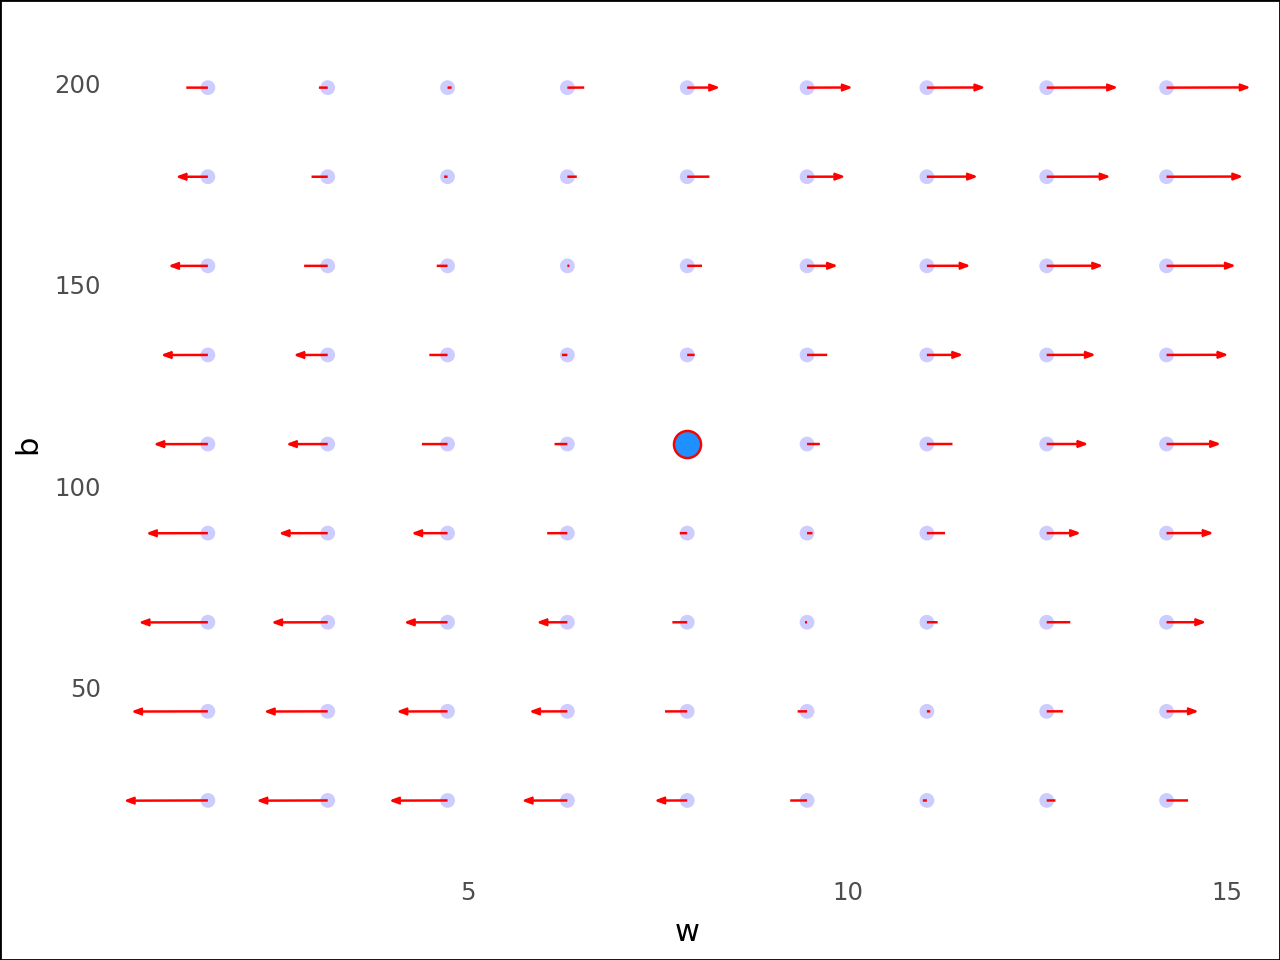

In [10]:
x = torch.tensor(temperature)
y = torch.tensor(icecream)

graphic_params = {
    "x": x,
    "y": y,
    "true_weight": reg["slope"],
    "true_bias": reg["intercept"],
    "grad_scale": 6000,
}

model_2p.plot_loss(**graphic_params)

Nous pouvons voir que les gradients sont presque tous « horizontaux ». Cela s'explique par le fait que nos deux paramètres n'ont pas la même échelle : une variation de 1 sur $w$ (la pente) aura un effet plus important sur la valeur de perte qu'une variation de 1 sur $b$ (l'interception).
Nous pouvons essayer de visualiser ce que cela signifie pour le processus d'apprentissage.

Dans le graphique suivant, nous représentons un processus d'apprentissage de 10 époques avec une
taille de pas de 0,001 commençant à $w = 2$ et $b = 50$.

/home/tim/miniconda3/lib/python3.13/site-packages/polars/_utils/construction/dataframe.py:717: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


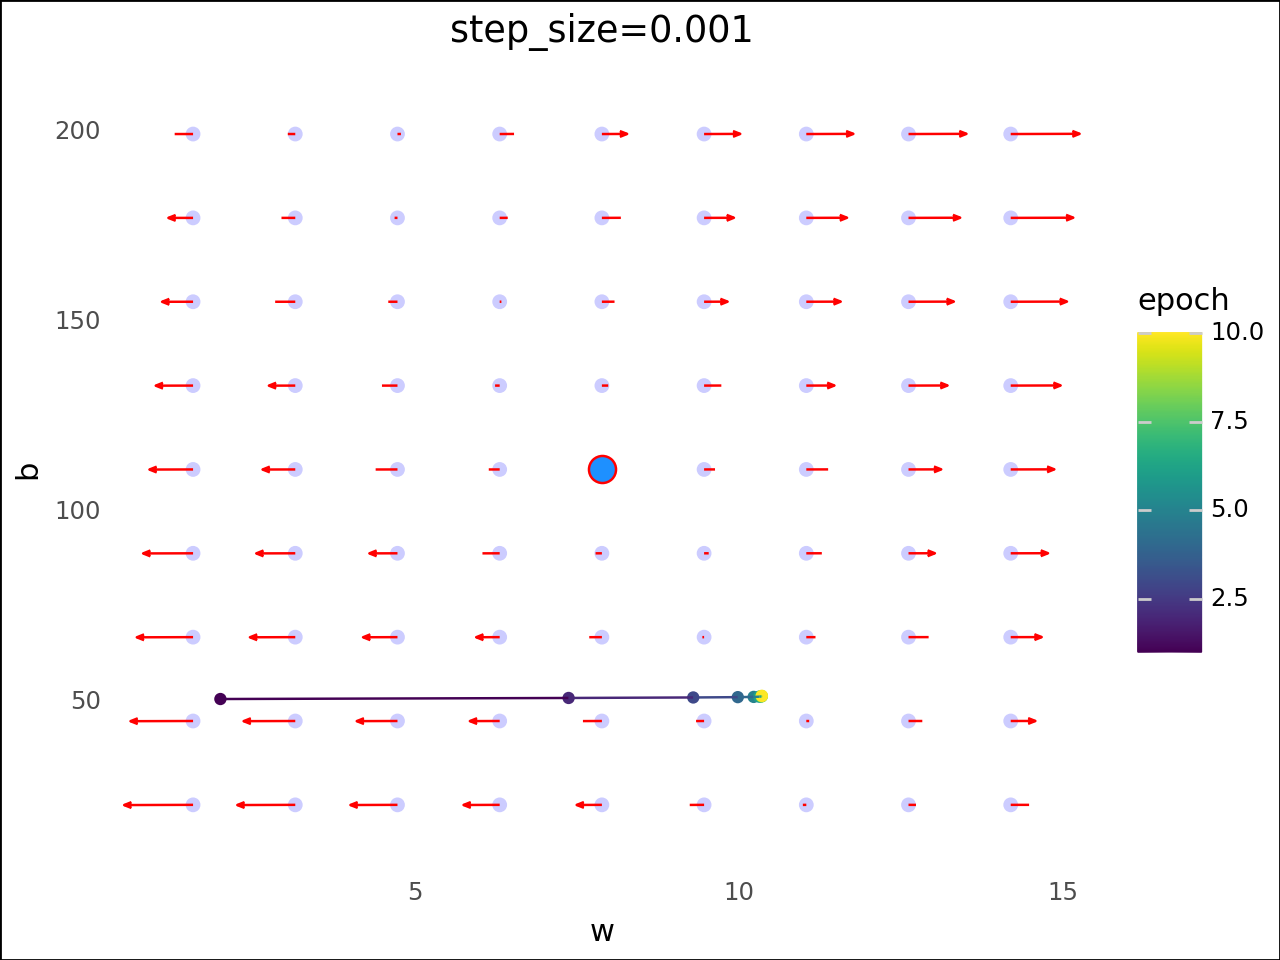

In [11]:
graphic_params.update({"w_init": 2.0, "b_init": 50.0})
model_2p.plot_train(
    step_size=0.001,
    epochs=10,
    **graphic_params,
)


Nous devons augmenter considérablement le nombre d'époques pour voir le processus d'entraînement
se rapprocher de la valeur optimale.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


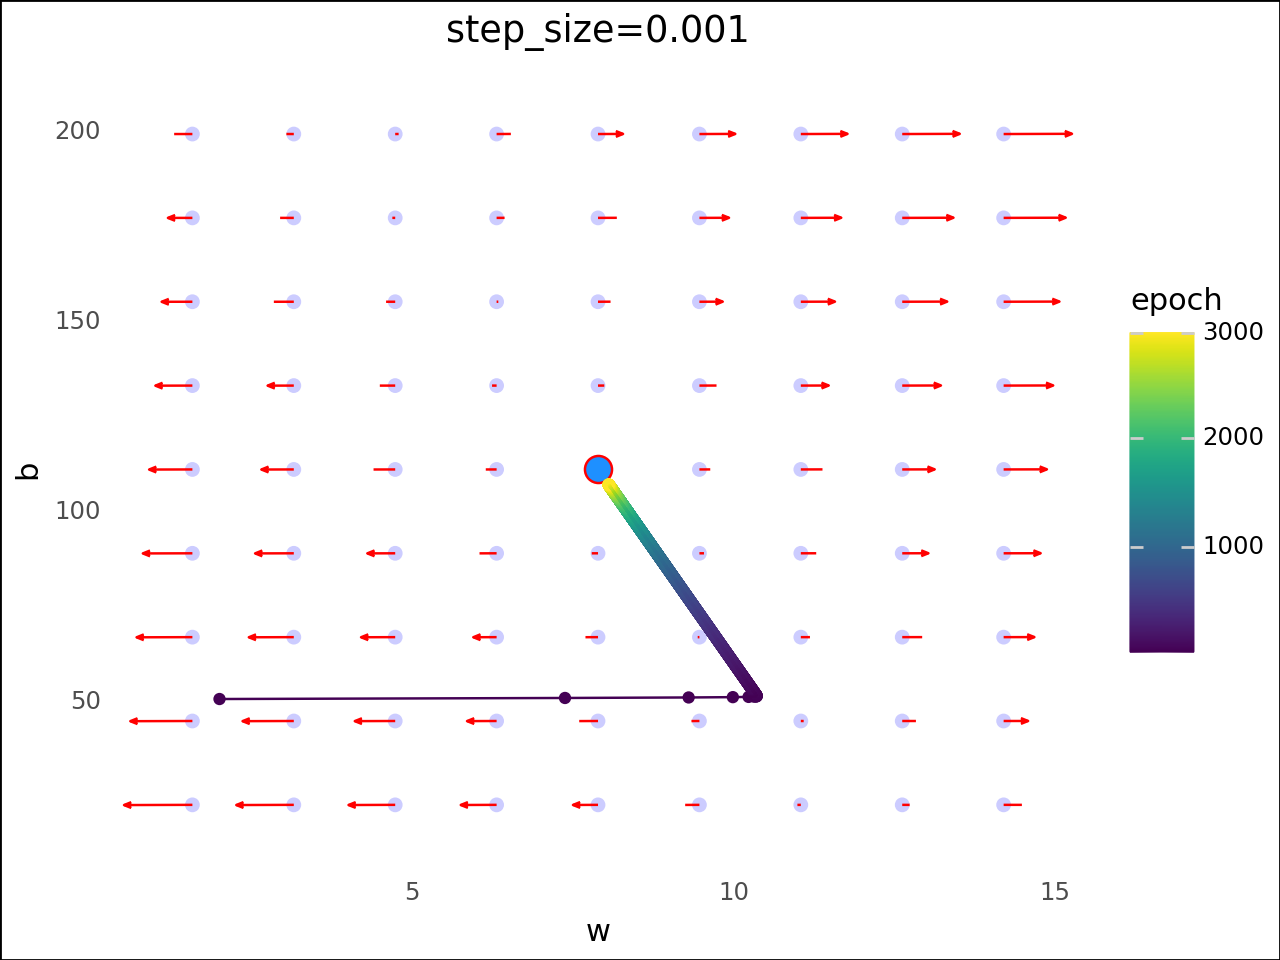

In [12]:
model_2p.plot_train(
    step_size=0.001,
    epochs=3000,
    **graphic_params,
)

Si nous augmentons la taille du pas à 0,003, nous pouvons voir que la
descente de gradient horizontale est plus « chaotique ». Cependant, le processus d'apprentissage se rapproche
un peu plus rapidement de l'optimum.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


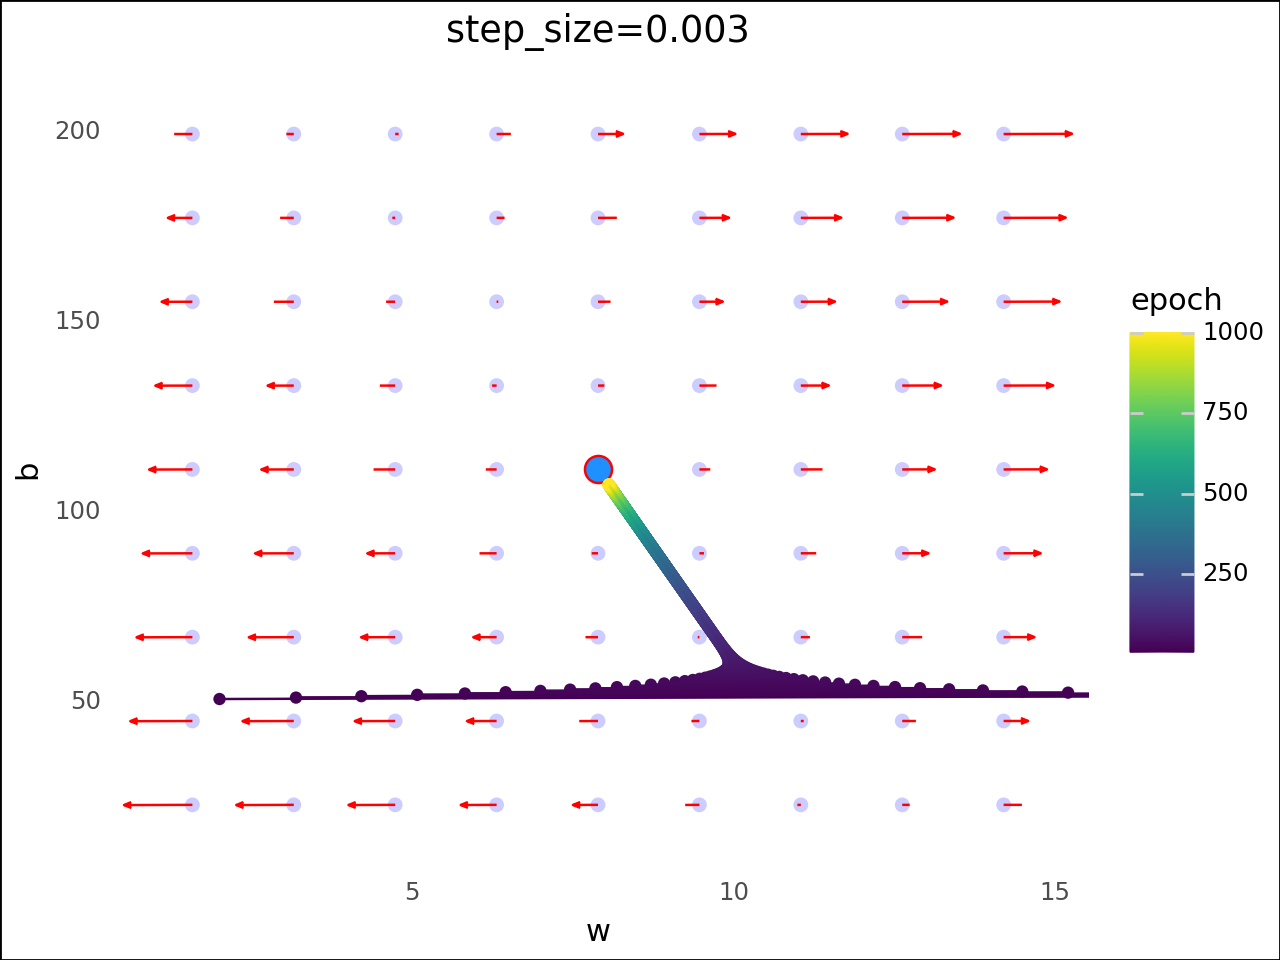

In [13]:
model_2p.plot_train(
    step_size=0.003,
    epochs=1000,
    **graphic_params,
)

# Regression avec pytorch sur des données transformé

Une manière d'améliorer le processus d'entraînement est de transformer les données pour que les poids et le biai soit une "échelle" plus similaire.

## Standardisation des données 

Premièrement nous allons essayés de standardiser les températures entre 0 et 1 en appliquant `preprocessing.minmax_scale`.

In [16]:
from sklearn import preprocessing

temp_n = preprocessing.minmax_scale(temperature)
print(temp_n)

[0.         0.04857143 0.14       0.16       0.26571429 0.42571429
 0.55714286 0.65714286 0.95714286 1.        ]


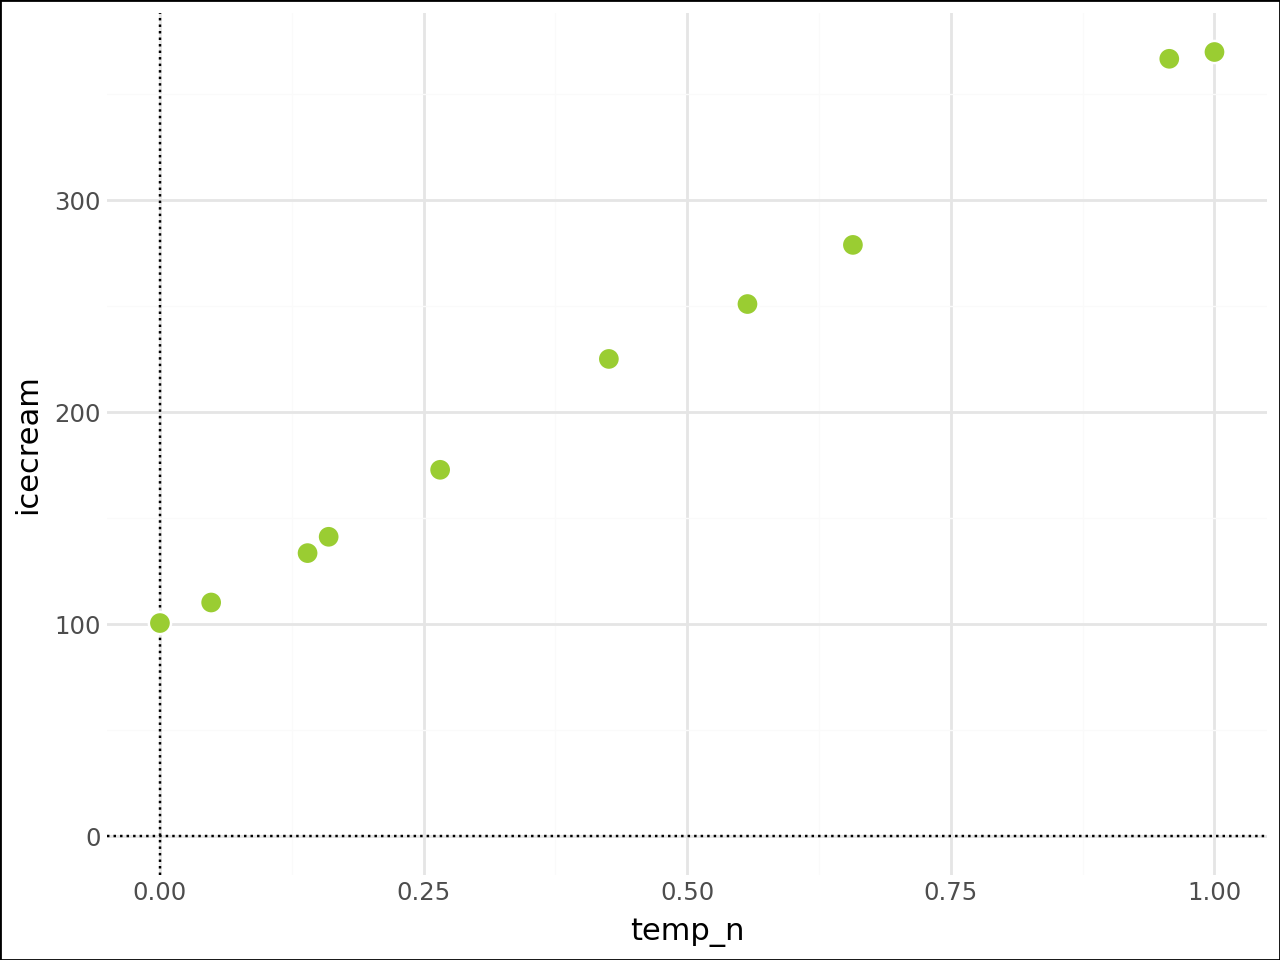

In [17]:
(
    pn.ggplot(mapping=pn.aes(x=temp_n, y=icecream))
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.geom_vline(xintercept=0, linetype="dotted")
    + pn.geom_point(color="white", fill="yellowgreen", size=4)
    + pn.labs(x="temp_n", y="icecream")
)

On peut calculer les nouveaux optimum de poid et de biais avec scikit-learn.

In [18]:
reg_n = skl_regression(temp_n, icecream)
print(f"slope: {reg_n['slope']:.2f}, intercept: {reg_n['intercept']:.2f}")

slope: 276.16, intercept: 98.68


Si on lance pytorch sur les données transformées, on peut voir qu'avec un grand learning_rate, l'entraînement semble commencer à converger vers les vrai valeurs.

In [22]:
x_n = torch.tensor(temp_n, dtype=torch.float)
training_model2d(x_n, icecream, 0.0, 0.0, epochs=20, learning_rate=0.4)

Epoch 1: loss=55261.4921875, gradient.w: -246.47653198242188, w=98.59061431884766, gradient.b:-429.96002197265625,  b=171.9840087890625
Epoch 2: loss=3750.260986328125, gradient.w: -43.29530334472656, w=115.90873718261719, gradient.b:-2.9505200386047363,  b=173.16421508789062
Epoch 3: loss=3104.30126953125, gradient.w: -32.05664825439453, w=128.7313995361328, gradient.b:13.996705055236816,  b=167.56553649902344
Epoch 4: loss=2634.396240234375, gradient.w: -29.187055587768555, w=140.40621948242188, gradient.b:13.59969711303711,  b=162.1256561279297
Epoch 5: loss=2236.076171875, gradient.w: -26.862722396850586, w=151.15130615234375, gradient.b:12.553464889526367,  b=157.10426330566406
Epoch 6: loss=1898.3157958984375, gradient.w: -24.735885620117188, w=161.045654296875, gradient.b:11.561103820800781,  b=152.47982788085938
Epoch 7: loss=1611.908447265625, gradient.w: -22.777950286865234, w=170.15682983398438, gradient.b:10.64610481262207,  b=148.2213897705078
Epoch 8: loss=1369.0462646484

/tmp/ipykernel_29237/3263311217.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


Si nous représentons graphiquement la perte en différents points, nous pouvons voir que les valeurs et
les orientations des gradients sont très différentes.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


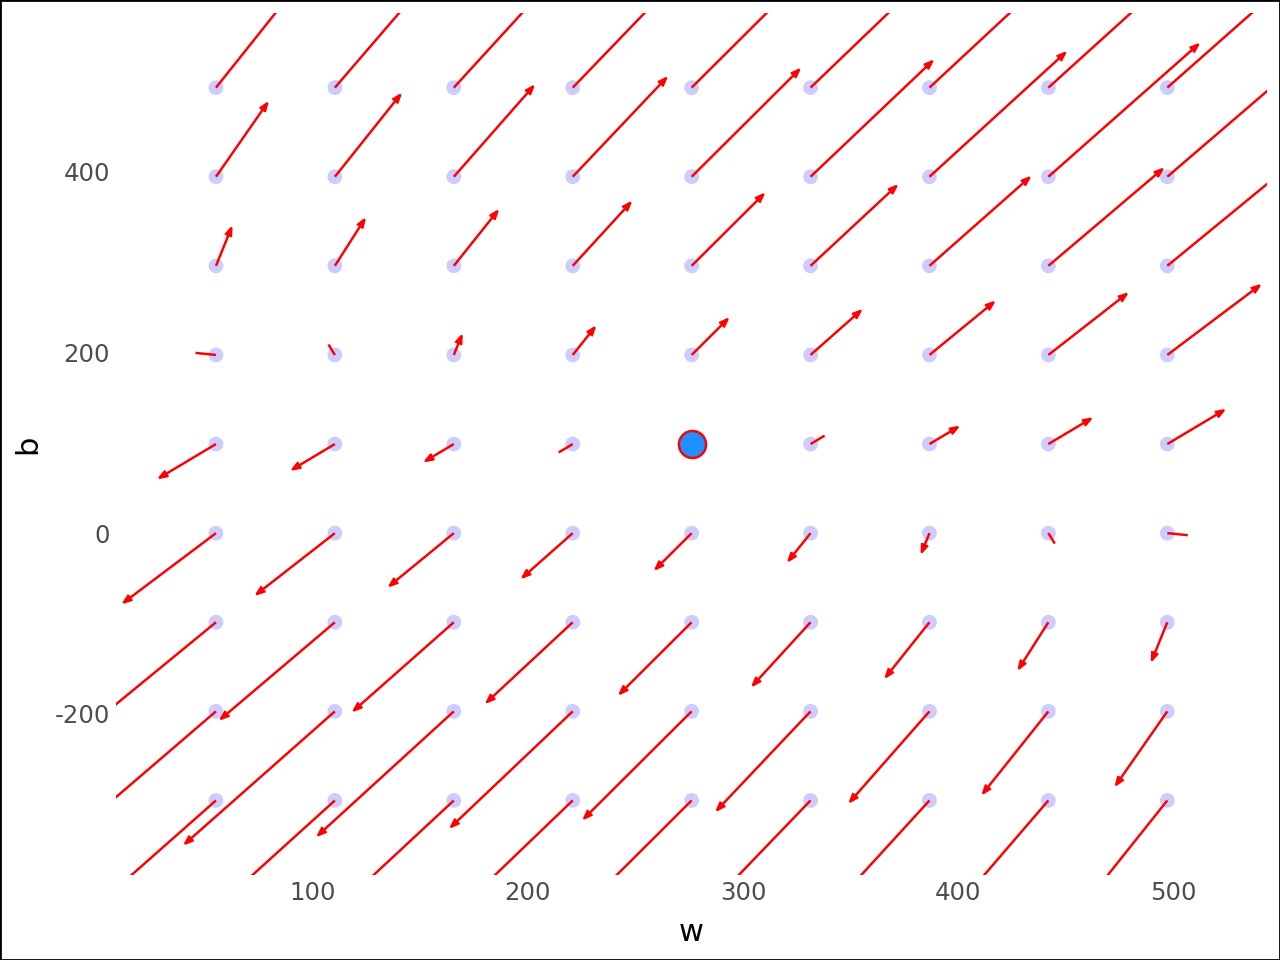

In [23]:
graphic_params_n = {
    "x": x_n,
    "y": y,
    "true_weight": reg_n["slope"],
    "true_bias": reg_n["intercept"],
    "grad_scale": 5,
    "b_factor": 4,
}
model_2p.plot_loss(**graphic_params_n)

Si nous ajoutons la visualisation d'un processus d'apprentissage avec une taille de pas de
0,4, nous pouvons voir que le processus converge beaucoup plus rapidement vers la
valeur optimale, qui est atteinte en environ 50 époques.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


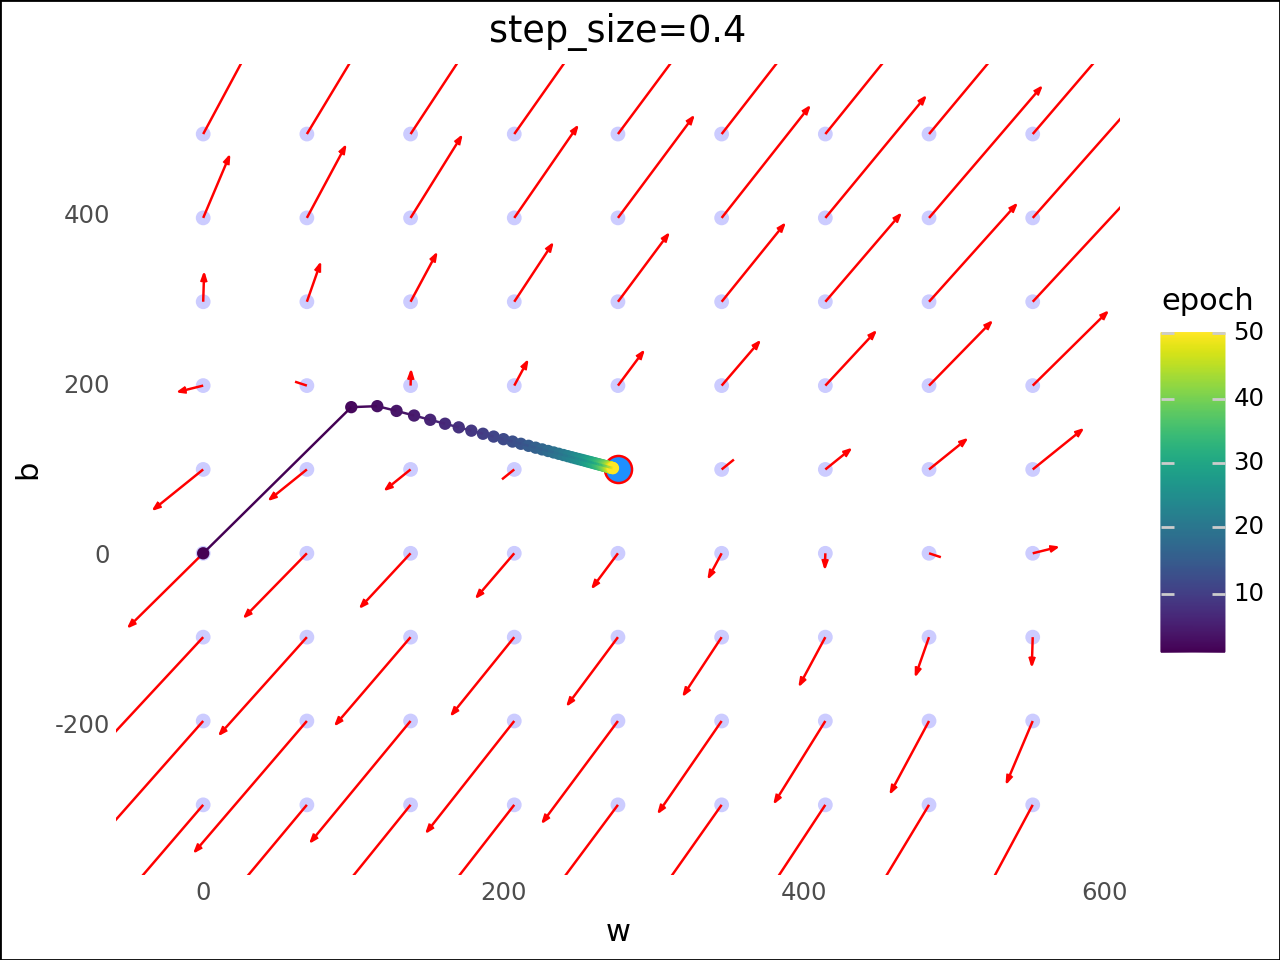

In [24]:
graphic_params_n.update({"w_init": 0.0, "b_init": 0.0, "w_factor": 1.0})
model_2p.plot_train(**graphic_params_n, step_size=0.4, epochs=50)

Vous pouvez jouer avec le learning_rate et le nombre d'epoch pour observer les différents comportements.

# Normalisation des données

On peut églament normaliser les données en enlevant la moyenne et en divisant par l'erreur standard. On peut le faire facilement en uitilisant `scale` de scikit-learn.

In [26]:
from sklearn import preprocessing

temp_s = preprocessing.scale(temperature, with_mean=True)
print(temp_s)

[-1.22384394 -1.08269505 -0.81700301 -0.75888288 -0.45167646  0.0132846
  0.3952169   0.68581757  1.55761956  1.6821627 ]


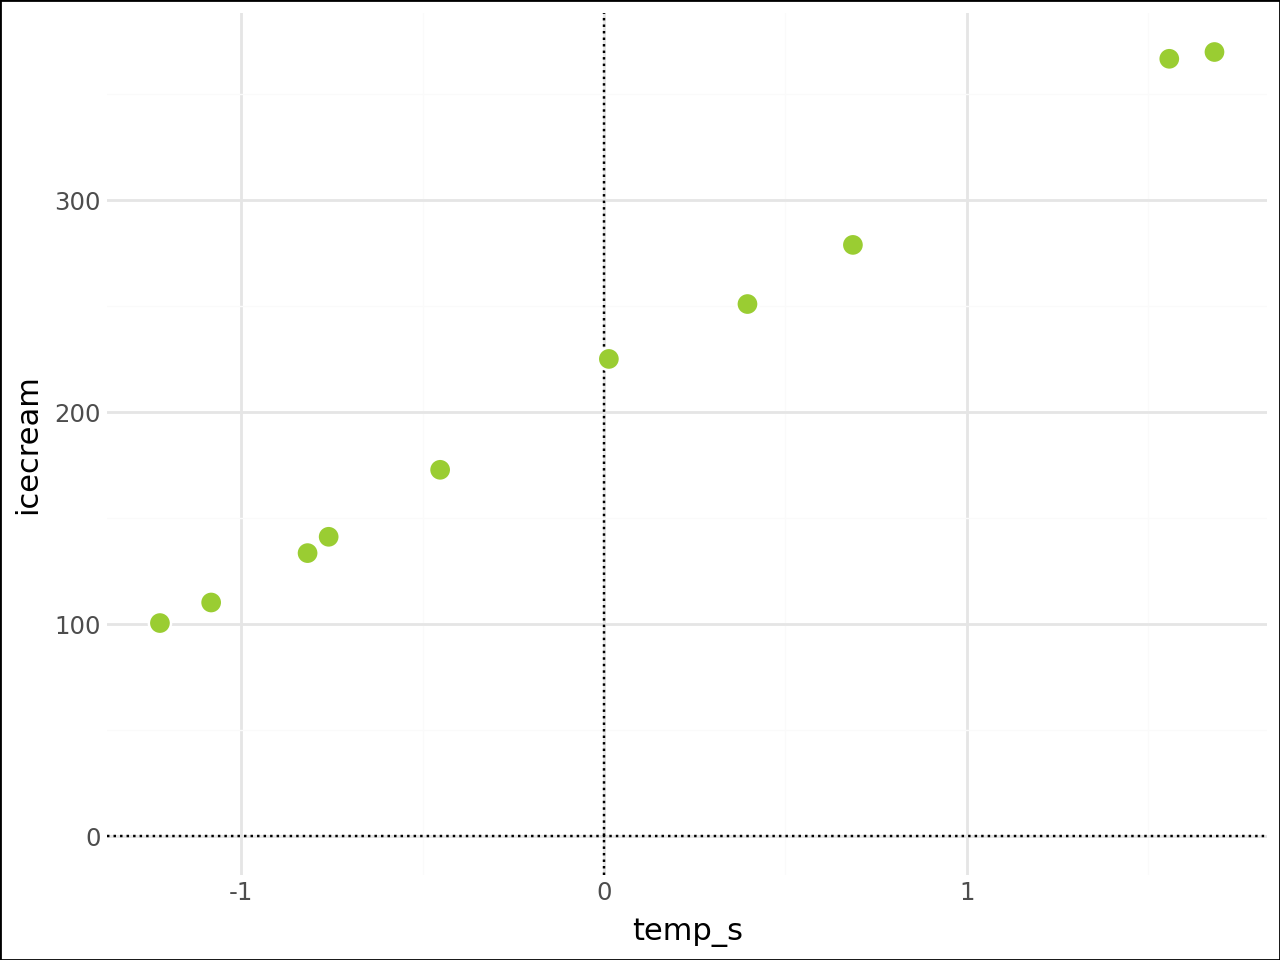

In [27]:
(
    pn.ggplot(mapping=pn.aes(x=temp_s, y=icecream))
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.geom_vline(xintercept=0, linetype="dotted")
    + pn.geom_point(color="white", fill="yellowgreen", size=4)
    + pn.labs(x="temp_s", y="icecream")
)

On va calculer le nouveau optimum.

In [28]:
reg_s = skl_regression(temp_s, icecream)
print(f"slope: {reg_s['slope']:.2f}, intercept: {reg_s['intercept']:.2f}")

slope: 95.03, intercept: 214.98


In [29]:
x_s = torch.tensor(temp_s, dtype=torch.float)
training_model2d(x_s, icecream, 0.0, 0.0, epochs=10, learning_rate=0.3)

Epoch 1: loss=55261.4921875, gradient.w: -190.05845642089844, w=57.017539978027344, gradient.b:-429.96002197265625,  b=128.98800659179688
Epoch 2: loss=8854.05078125, gradient.w: -76.02336883544922, w=79.82455444335938, gradient.b:-171.98399353027344,  b=180.5832061767578
Epoch 3: loss=1428.8616943359375, gradient.w: -30.40934944152832, w=88.94735717773438, gradient.b:-68.79358673095703,  b=201.22128295898438
Epoch 4: loss=240.8317413330078, gradient.w: -12.163738250732422, w=92.59648132324219, gradient.b:-27.51743507385254,  b=209.4765167236328
Epoch 5: loss=50.746864318847656, gradient.w: -4.86548376083374, w=94.0561294555664, gradient.b:-11.006962776184082,  b=212.7786102294922
Epoch 6: loss=20.33332061767578, gradient.w: -1.9461885690689087, w=94.63998413085938, gradient.b:-4.402773857116699,  b=214.0994415283203
Epoch 7: loss=15.467228889465332, gradient.w: -0.7784819006919861, w=94.87352752685547, gradient.b:-1.761122226715088,  b=214.62777709960938
Epoch 8: loss=14.6885585784912

/tmp/ipykernel_29237/3263311217.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


Nous pouvons à nouveau essayer de visualiser les gradients de perte et les valeurs le long d'une
grille de valeurs $w$ et $b$. Nous voyons que le contour de notre perte semble
plus circulaire, et que le gradient semble pointer directement dans la direction opposée
à l'optimum.

/home/tim/miniconda3/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


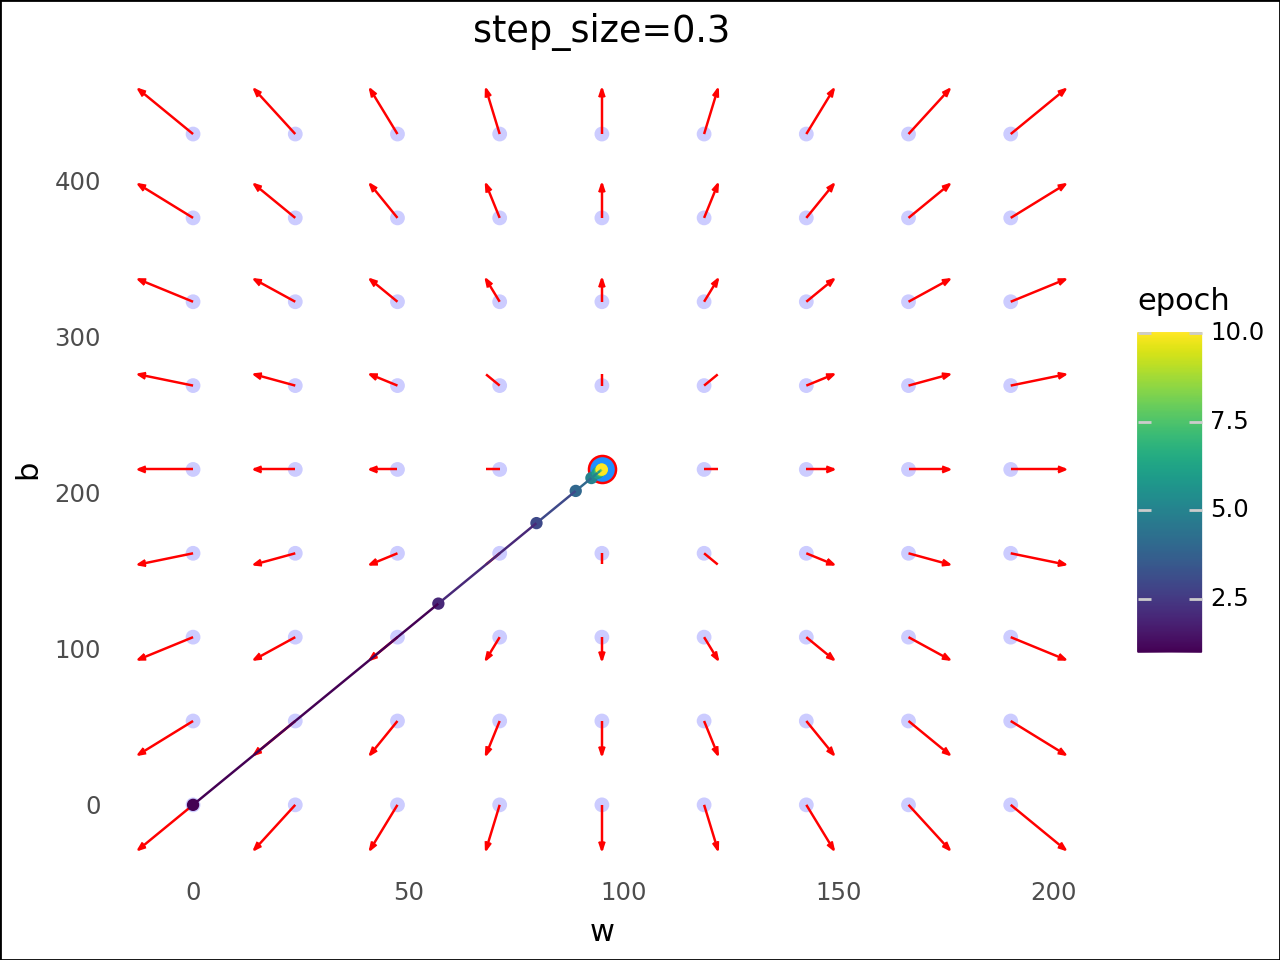

In [32]:
graphic_params_s = {
    "x": x_s,
    "y": y,
    "true_weight": reg_s["slope"],
    "true_bias": reg_s["intercept"],
    "grad_scale": 15,
}

graphic_params_s.update({"w_init": 0.0, "b_init": 0.0, "w_factor": 1.0, "b_factor": 1.0})
model_2p.plot_train(**graphic_params_s, step_size=0.3, epochs=10)